In [589]:
import pandas as pd
import numpy as np
from scipy import sparse
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split

In [590]:
class LogisticRegression(object):
    def __init__(self, X_train, y_train, X_test, y_test, X_validation, y_validation, learn_rate=0.001, n_iters=500):
        # Verify shape of train set
        if len(X_train.shape) == 1:
            self.X_train = np.hstack((np.array([1]), X_train))
        else:
            self.X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        self.y_train = y_train  # Init y

        # Verify shape of test set
        if len(X_test.shape) == 1:
            self.X_test = np.hstack((np.array([1]), X_test))
        else:
            self.X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        self.y_test = y_test  # Init y

        # Verify shape of valid set
        if len(X_validation.shape) == 1:
            self.X_validation = np.hstack((np.array([1]), X_validation))
        else:
            self.X_validation = np.hstack((np.ones((X_validation.shape[0], 1)), X_validation))
        self.y_validation = y_validation  # Init y
        
        # Init lr and iters
        self.learn_rate = learn_rate
        self.n_iters = n_iters 

        # Initialize model weights
        self.weight = np.zeros((self.X_train.shape[1]))

        self.accuracy_train = []  # To keep track of accuracy on the training data during gradient ascent process
        self.accuracy_test = []  # To keep track of accuracy on the test data during gradient ascent process
        self.accuracy_validation = []  # To keep track of accuracy on the valid data during gradient ascent process

        self.log_likelihood_train = []  # To keep track of average log likelihood on the training data during gradient ascent process
        self.log_likelihood_test = []  # To keep track of average log likelihood on the test data during gradient ascent process
        self.log_likelihood_validation = []  # To keep track of average log likelihood on the valid data during gradient ascent process

    def predict(self, samples, threshold=0.5):
        return self.predict_prob(samples) >= threshold

    def predict_prob(self, samples):
        # Ensure samples have intercept
        if samples.shape[1] == self.weight.shape[0] - 1:
            samples = np.hstack([np.ones((samples.shape[0], 1)), samples])
            
        # Dot product
        linear_combination = np.dot(samples, self.weight)
        
        # Apply sigmoid
        prob = 1 / (1 + np.exp(-linear_combination))
        
        return prob


    def compute_gradient(self):
        """ Compute and return gradient of the average log-likelihood objective. """
        linear_combination = np.dot(self.X_train, self.weight)
        prob = 1 / (1 + np.exp(-linear_combination))
        
        # calc gradient
        gradient = np.dot(self.X_train.T, (self.y_train - prob)) / self.X_train.shape[0]
        
        return gradient
    
    def gradient_ascent(self):
        """ Optimize model weights using gradient ascent. """
        for i in range(self.n_iters):
            # calc gradient
            gradient = self.compute_gradient()
            
            # update weights
            self.weight += self.learn_rate * gradient
            
            # Compute/store log likelihoods
            self.log_likelihood_train.append(self.compute_log_likelihood(self.X_train, self.y_train))
            self.log_likelihood_test.append(self.compute_log_likelihood(self.X_test, self.y_test))
            self.log_likelihood_validation.append(self.compute_log_likelihood(self.X_validation, self.y_validation))
            
            # Compute and store prediction accuracies
            self.accuracy_train.append(self.compute_accuracy(self.X_train, self.y_train))
            self.accuracy_test.append(self.compute_accuracy(self.X_test, self.y_test))
            self.accuracy_validation.append(self.compute_accuracy(self.X_validation, self.y_validation))
    
            
    def compute_log_likelihood(self, X, y):
        # Compute predicted probs
        linear_combination = np.dot(X, self.weight)
        prob = 1 / (1 + np.exp(-linear_combination))
        
        # Compute log likelihood
        log_likelihood = np.sum(y * np.log(prob) + (1 - y) * np.log(1 - prob))
        
        return log_likelihood / len(y)
    
    def compute_accuracy(self, X, y):
        # Predict labels
        predictions = self.predict(X)
        
        # Compute accuracy
        return np.mean(predictions == y)
        

In [591]:
def preprocess_data(X_train, X_test, X_validation):
    # ID categorical and numerical columns
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X_train.select_dtypes(include=['number']).columns
    
    # Create a column transformer with OneHotEncoder and StandardScaler
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
    
    # Fit and transform data
    X_train_transformed = preprocessor.fit_transform(X_train)
    # Transform test data
    X_test_transformed = preprocessor.transform(X_test)
    # Fit and transform validation data
    X_validation_transformed = preprocessor.transform(X_validation)

    if sparse.issparse(X_train_transformed):
        X_train_transformed = X_train_transformed.toarray()
    if sparse.issparse(X_test_transformed):
        X_test_transformed = X_test_transformed.toarray()
    if sparse.issparse(X_validation_transformed):
        X_validation_transformed = X_validation_transformed.toarray() 

    return X_train_transformed, X_test_transformed, X_validation_transformed

In [592]:
def plot_log_likelihood_performance(log_likelihood_train, log_likelihood_test, log_likelihood_validation):
    # Create fig
    plt.figure(figsize=(10, 6))
    
    # Plot log likelihood
    plt.plot(log_likelihood_train, label='Train Log Likelihood', color='blue')
    
    # Plot log likelihood for test set
    plt.plot(log_likelihood_test, label='Test Log Likelihood', color='red')
    
    # Plot log likelihood for validation set
    plt.plot(log_likelihood_validation, label='Validation Log Likelihood', color='green')
    
    # Add labels and title
    plt.xlabel('Iterations')
    plt.ylabel('Average Log Likelihood')
    plt.title('Log Likelihood during Gradient Ascent')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

In [593]:
def plot_accuracy_performance(accuracy_train, accuracy_test, accuracy_validation):
    # Create a fig
    plt.figure(figsize=(10, 6))
    
    # Plot the accuracy for the training set
    plt.plot(accuracy_train, label='Training Accuracy', color='blue')
    
    # Plot the accuracy for test set
    plt.plot(accuracy_test, label='Test Accuracy', color='red')
    
    # Plot the accuracy for the validation set
    plt.plot(accuracy_validation, label='Validation Accuracy', color='green')
    
    # Add labels, title
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during Gradient Ascent')
    
    # Legend
    plt.legend()
    
    # Show
    plt.show()

In [594]:
def plot_roc(X_train, y_train, X_test, y_test, X_validation, y_validation, learner):
    # Calc probs of the positive class
    probs_train = learner.predict_prob(X_train)
    probs_test = learner.predict_prob(X_test)
    probs_validation = learner.predict_prob(X_validation)
    
    # Compute ROC curve and area underneath for training
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Compute ROC curve and area underneath for testing
    fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Compute ROC curve and area underneath for validation
    fpr_validation, tpr_validation, _ = roc_curve(y_validation, probs_validation)
    roc_auc_validation = auc(fpr_validation, tpr_validation)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC Curve (area = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC Curve (area = {roc_auc_test: .2f})')
    plt.plot(fpr_validation, tpr_validation, color='green', lw=2, label=f'Validation ROC Curve (area = {roc_auc_validation: .2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [595]:
# Load data
train_data = pd.read_csv('cleaned_train_data.csv')
test_data = pd.read_csv('cleaned_test_data.csv')
validation_data = pd.read_csv('cleaned_validation_data.csv')
X_train = train_data.drop(['price'], axis=1, inplace=False)
X_validation = validation_data.drop(['price'], axis=1, inplace=False)
y_train = train_data['price']
X_test = test_data.drop(['price'], axis=1, inplace=False)
y_test = test_data['price']
y_validation = validation_data['price']

In [596]:
# Preprocessing data
processed_X_train, processed_X_test, processed_X_validation = preprocess_data(X_train, X_test, X_validation)

In [597]:
# Run gradient ascent with Logistic Regression
learner = LogisticRegression(processed_X_train, y_train.values, processed_X_test, y_test.values, processed_X_validation, y_validation.values,
                               n_iters=500, learn_rate=0.75)
learner.gradient_ascent()

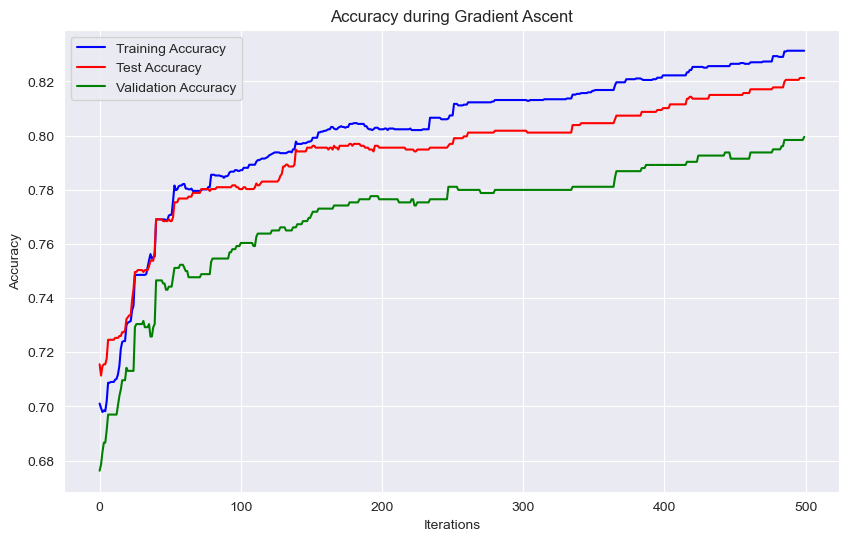

In [598]:
# Plot prediction accuracy during training process
plot_accuracy_performance(learner.accuracy_train, learner.accuracy_test, learner.accuracy_validation)

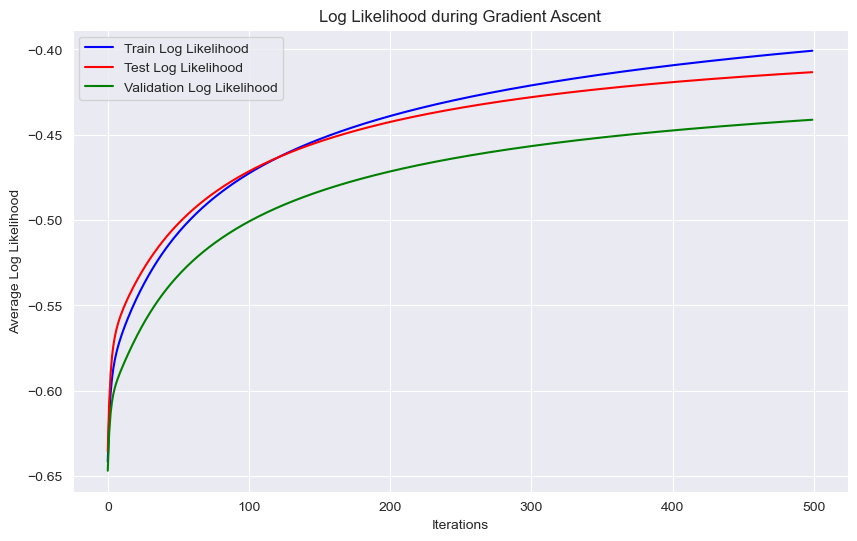

In [599]:
# Plot Log Likelihood values during training process
plot_log_likelihood_performance(learner.log_likelihood_train, learner.log_likelihood_test, learner.log_likelihood_validation)

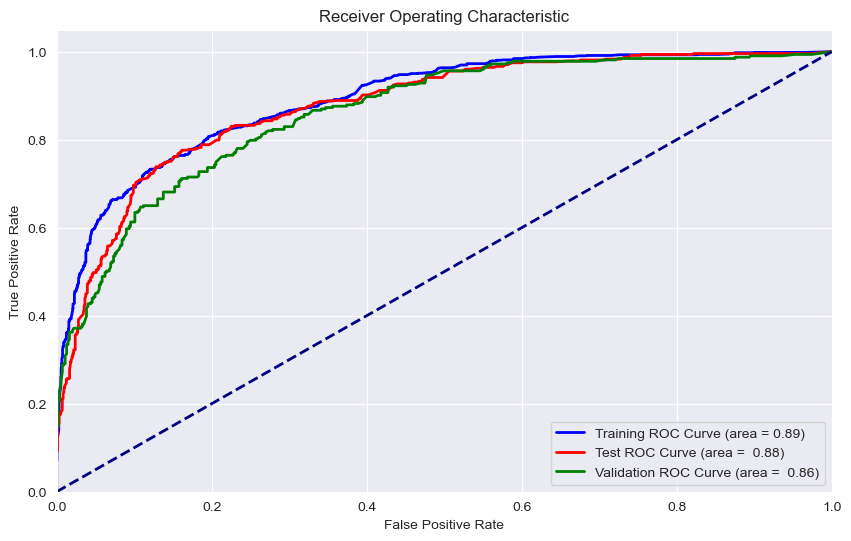

In [600]:
# Plot ROC curves
plot_roc(processed_X_train, y_train, processed_X_test, y_test, processed_X_validation, y_validation, learner)

In [601]:
def DecisionTree(processed_X_train, processed_X_test, processed_X_validation):
    # Initialize the DecisionTreeClassifier
    decision_tree = DecisionTreeClassifier(random_state=42)
    
    # Train the model
    decision_tree.fit(processed_X_train, y_train)
    
    # Predict on the training, test, and validation sets
    y_pred_train = decision_tree.predict(processed_X_train)
    y_pred_test = decision_tree.predict(processed_X_test)
    y_pred_validation = decision_tree.predict(processed_X_validation)
    
    # Calculate the accuracy of the model on each set
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    
    # Print the accuracies
    print(f"Training Accuracy of the Decision Tree: {accuracy_train:.4f}")
    print(f"Testing Accuracy of the Decision Tree: {accuracy_test:.4f}")
    print(f"Validation Accuracy of the Decision Tree: {accuracy_validation:.4f}")

In [602]:
DecisionTree(processed_X_train, processed_X_test, processed_X_validation)

Training Accuracy of the Decision Tree: 0.9144
Testing Accuracy of the Decision Tree: 0.8352
Validation Accuracy of the Decision Tree: 0.8157


In [603]:
def RandomForest(processed_X_train, processed_X_test, processed_X_validation):
    # Train the Random Forest model
    random_forest = RandomForestClassifier(random_state=42)
    random_forest.fit(processed_X_train, y_train)
    
    # Predict and evaluate on the training set
    y_pred_train = random_forest.predict(processed_X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    print(f"Training Accuracy of the Random Forest: {accuracy_train:.4f}")
    
    # Predict and evaluate on the testing set
    y_pred_test = random_forest.predict(processed_X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f"Testing Accuracy of the Random Forest: {accuracy_test:.4f}")
    
    # Predict and evaluate on the validation set
    y_pred_validation = random_forest.predict(processed_X_validation)
    accuracy_validation = accuracy_score(y_validation, y_pred_validation)
    print(f"Validation Accuracy of the Random Forest: {accuracy_validation:.4f}")

In [604]:
RandomForest(processed_X_train, processed_X_test, processed_X_validation)

Training Accuracy of the Random Forest: 0.9144
Testing Accuracy of the Random Forest: 0.8345
Validation Accuracy of the Random Forest: 0.8203


In [605]:
def SVM(processed_X_train, y_train, processed_X_test, y_test, processed_X_validation, y_validation):
    # Using a linear kernel
    svm_linear = make_pipeline(StandardScaler(with_mean=False), SVC(kernel='linear', random_state=42))
    svm_linear.fit(processed_X_train, y_train)

    # Predictions for linear kernel
    y_pred_train_linear = svm_linear.predict(processed_X_train)
    y_pred_test_linear = svm_linear.predict(processed_X_test)
    y_pred_validation_linear = svm_linear.predict(processed_X_validation)

    # Reports for linear kernel
    print('Linear Kernel SVM Classifier Report for Training Set:')
    print(classification_report(y_train, y_pred_train_linear))
    print('Linear Kernel SVM Classifier Report for Testing Set:')
    print(classification_report(y_test, y_pred_test_linear))
    print('Linear Kernel SVM Classifier Report for Validation Set:')
    print(classification_report(y_validation, y_pred_validation_linear))

    # Using an RBF kernel
    svm_rbf = make_pipeline(StandardScaler(with_mean=False), SVC(kernel='rbf', random_state=42))
    svm_rbf.fit(processed_X_train, y_train)

    # Predictions for RBF kernel
    y_pred_train_rbf = svm_rbf.predict(processed_X_train)
    y_pred_test_rbf = svm_rbf.predict(processed_X_test)
    y_pred_validation_rbf = svm_rbf.predict(processed_X_validation)

    # Reports for RBF kernel
    print('RBF Kernel SVM Classifier Report for Training Set:')
    print(classification_report(y_train, y_pred_train_rbf))
    print('RBF Kernel SVM Classifier Report for Testing Set:')
    print(classification_report(y_test, y_pred_test_rbf))
    print('RBF Kernel SVM Classifier Report for Validation Set:')
    print(classification_report(y_validation, y_pred_validation_rbf))

In [606]:
SVM(processed_X_train, y_train, processed_X_test, y_test, processed_X_validation, y_validation)

Linear Kernel SVM Classifier Report for Training Set:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2227
           1       0.90      0.82      0.85      1289

    accuracy                           0.90      3516
   macro avg       0.90      0.88      0.89      3516
weighted avg       0.90      0.90      0.90      3516

Linear Kernel SVM Classifier Report for Testing Set:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       960
           1       0.72      0.75      0.74       478

    accuracy                           0.82      1438
   macro avg       0.80      0.80      0.80      1438
weighted avg       0.82      0.82      0.82      1438

Linear Kernel SVM Classifier Report for Validation Set:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       545
           1       0.74      0.75      0.75       323

    accuracy       

In [607]:
def NeuralNet(processed_X_train, y_train, processed_X_test, y_test, processed_X_validation, y_validation):
    # scale datasets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(processed_X_train)
    X_test_scaled = scaler.transform(processed_X_test)
    X_validation_scaled = scaler.transform(processed_X_validation)

    # Convert scaled data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)
    X_validation_tensor = torch.FloatTensor(X_validation_scaled)
    y_validation_tensor = torch.LongTensor(y_validation)


    num_epochs = 50
    seeds = [42, 123, 56, 2001, 2000, 789, 101112, 50988, 69, 420]
    # Empty lists for tracking avg accuracies
    avg_train_accuracy, avg_valid_accuracy, avg_test_accuracy = [], [], []
    
    for seed in seeds:
        torch.manual_seed(seed)
        # Init Datasets and DataLoader
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
        validation_loader = DataLoader(dataset=validation_dataset, batch_size=64, shuffle=False)
    
        class NeuralNet(nn.Module):
            def __init__(self, input_size, num_classes):
                super(NeuralNet, self).__init__()
                self.fc1 = nn.Linear(input_size, 50)
                self.relu = nn.ReLU()  # Middle ReLU
                self.fc2 = nn.Linear(50, num_classes)
    
            def forward(self, x):
                out = self.fc1(x)
                out = self.relu(out)
                out = self.fc2(out)
                return out
    
        model = NeuralNet(X_train_tensor.shape[1], 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

        # Empty lists for tracking accuracies
        train_accuracy, valid_accuracy, test_accuracy = [], [], []
    
        for epoch in range(num_epochs):
            # Reset variables for each epoch
            train_correct, train_total, val_correct, val_total, test_correct, test_total = 0, 0, 0, 0, 0, 0

            model.train()
            # Train Eval
            for features, labels in train_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

            model.eval()
            with torch.no_grad():
                # Valid Eval
                for features, labels in validation_loader:
                    outputs = model(features)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                # Test Eval
                for features, labels in test_loader:
                    outputs = model(features)
                    _, predicted = torch.max(outputs.data, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

            # Append the accuracies for this epoch
            train_accuracy.append(100 * train_correct / train_total)
            valid_accuracy.append(100 * val_correct / val_total)
            test_accuracy.append(100 * test_correct / test_total)

        # Compute the average across all seeds after training
        if seed == seeds[0]:  # Initialize lists with the values from the first seed
            avg_train_accuracy, avg_valid_accuracy, avg_test_accuracy = train_accuracy, valid_accuracy, test_accuracy
        else:  # Average the current seed's accuracies with the previous seeds' averages
            avg_train_accuracy = [(p + n) / 2 for p, n in zip(avg_train_accuracy, train_accuracy)]
            avg_valid_accuracy = [(p + n) / 2 for p, n in zip(avg_valid_accuracy, valid_accuracy)]
            avg_test_accuracy = [(p + n) / 2 for p, n in zip(avg_test_accuracy, test_accuracy)]

    return avg_train_accuracy, avg_valid_accuracy, avg_test_accuracy

In [608]:
def plot_accuracy_nn_performance(avg_train_accuracy, avg_valid_accuracy, avg_test_accuracy):
    plt.figure(figsize=(10, 6))  # make plt object
    epochs = range(1, len(avg_train_accuracy) + 1)  # size of x

    # Plot training and test acc, as well as validation
    plt.plot(epochs, avg_train_accuracy, 'bo-', label='Training Accuracy')  # y-axis for train
    plt.plot(epochs, avg_test_accuracy, 'ro-', label='Test Accuracy')  # y-axis for test
    plt.plot(epochs, avg_valid_accuracy, 'go-', label='Validation Accuracy')


    # Title and Labels
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Legend
    plt.legend()
    plt.show()


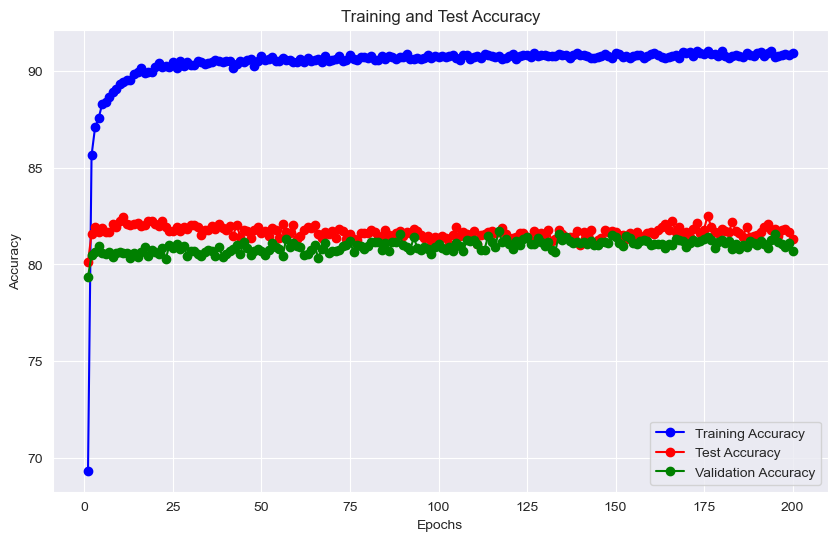

In [609]:
avg_train_accuracy, avg_valid_accuracy, avg_test_accuracy = NeuralNet(processed_X_train, y_train, processed_X_test, y_test, processed_X_validation, y_validation)

plot_accuracy_nn_performance(avg_train_accuracy, avg_valid_accuracy, avg_test_accuracy)